# Project II: Making a dynamical model of the Solar System
## Heine Jan Lindemulder
## s4001362
In this project I make a model of the Solar System and I animate it and present some interesting data. I have split it into three cell blocks, because I think this will make it less cluttered and a bit clearer. In the first cell block I animate the Solar System in 3D. In the second cell block I show a table with some interesting data and I show that energy is conserved. In the third cell block I show how the speed of a planet changes with respect to the distance from the Sun.

### The animation
In the first cell block I animate the Solar System in 3D. For this I use a class that I called SolarObject so the Sun and the planets all have the same properties and they are easily accessible. I use the astroquery library to pull the data from the JPL Horizons website. Using these queries makes it much easier to choose whatever starting date you want. This is a big advantage over just copying the data from the website manually. This date can be changed in the program.  
For the calculations of the trajectory, I use the leapfrog integration method. This method is especially useful for orbital dynamics, because it conserves energy in contrast to, for example, the Runge-Kutta method. I found this information and an implementation on the Wikipedia page about leapfrog integration (https://en.wikipedia.org/wiki/Leapfrog_integration).  
For the integration I use a step-value of one day, which is small enough for the Sun and the planets. The Moon can also be included, but then the step-value should be 0.1 days or less. This is because the Moon has a relatively short orbital period, so a small step-size is needed. Also, I have prepared the code to animate the Moon, the only thing you have to do is comment and decomment a few lines. These lines are specified in the code.  
In the animation I just show the Sun and the first four planets, because if I were to show all the planets, the first four planets are barely visible. It is possible to also view the rest of the planets, this is just a simple matter of commenting and decommenting a few lines. Once again, this is specified in the code.  
I use the matplotlib animation library to animate the Solar System in 3D.

<IPython.core.display.Javascript object>


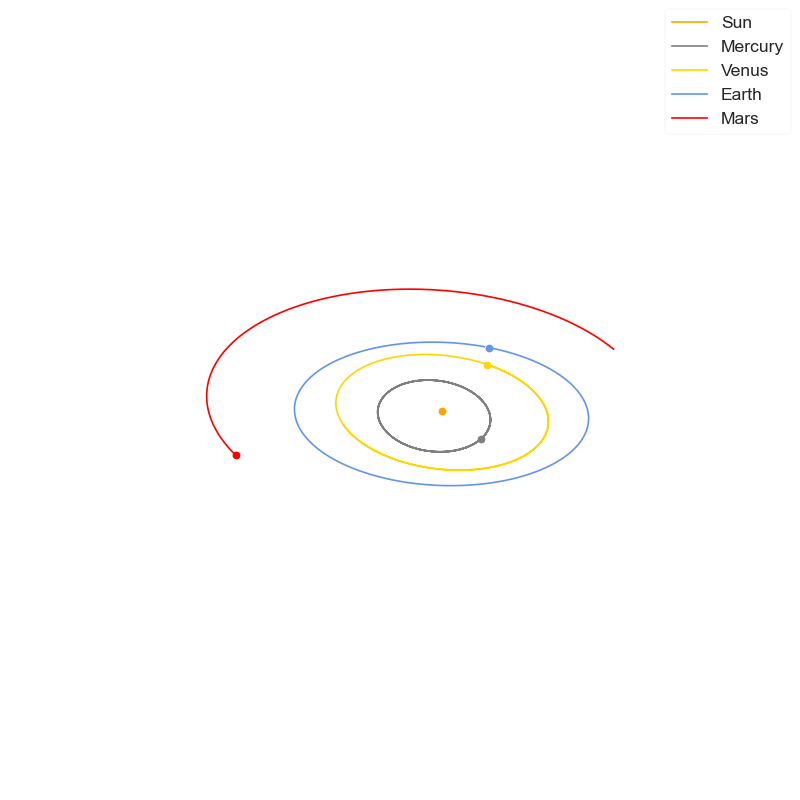

In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from astroquery.jplhorizons import Horizons
from astropy.time import Time

class SolarObject:
    """
    This class creates a solar object. When initiating a new solar object, the name, color and mass are required.
    When created, the objects get many variables which are used to store the data that is calculated further on.
    """
    def __init__(self, name, color, mass):
        self.name = name
        self.color = color
        self.mass = mass
        self.r = np.array([])
        self.vel = np.array([])
        self.xcord = np.array([])
        self.ycord = np.array([])
        self.zcord = np.array([])

def func(num, data, line, dot):
    """
    This function helps with the animation. It gets its data from the animation function and then
    returns the data that has to be animated.
    """
    for i in range(len(data)):
        # The data for the lines is the x-, y- and z-coordinates
        # It also uses all the data that has been used, to make sure the line stays visible
        line[i].set_data(data[i][0:2, :num])
        line[i].set_3d_properties(data[i][2, :num])
        # For the dots on the lines only the last bit of data is necessary
        dot[i].set_data(data[i][0:2, num-1:num])
        dot[i].set_3d_properties(data[i][2, num-1:num])
    return line, dot

# This is the gravitational constant in AU^3 * kg^-1 * day^-2
G = 6.67428e-11 * 86400**2 / (1.495978707e11)**3

# Here I create all of the solar objects needed for the simulation
sun = SolarObject("Sun", "orange", 1.9885e30)
mercury = SolarObject("Mercury", "grey", 3.302e23)
venus = SolarObject("Venus", "gold", 4.8685e24)
earth = SolarObject("Earth", "cornflowerblue", 5.97219e24)
moon = SolarObject("Moon", "silver", 7.349e22)
mars = SolarObject("Mars", "red", 6.4171e23)
jupiter = SolarObject("Jupiter", "saddlebrown", 1.89818722e27)
saturn = SolarObject("Saturn", "sandybrown", 5.6834e26)
uranus = SolarObject("Uranus", "paleturquoise", 8.6813e25)
neptune = SolarObject("Neptune", "mediumblue", 1.02413e26)

# Here you can change the startdate to whatever you want in the format yyyy-mm-dd
startdate = Time("2021-01-01").jd
# These are the id's that JPL Horizons uses for the Sun and the planets
# Line 60 also contains the id for the moon, if you want that as well
ids = np.array([10, 199, 299, 399, 499, 599, 699, 799, 899])
#ids = np.array([10, 199, 299, 399, 301, 499, 599, 699, 799, 899])

# This is a list with all planets to ensure easier calculations
# Line 64 also contains the moon, if you want that as well
objects = np.array([sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune])
#objects = np.array([sun, mercury, venus, earth, moon, mars, jupiter, saturn, uranus, neptune])

# In this loop all the necessary starting date is added
# The Horizons function fetches the data from JPL and then the data is stored for each object
for i in range(len(objects)):
    obj = Horizons(id = ids[i], location = "@sun", epochs = startdate, id_type = 'id').vectors()
    objects[i].r = np.array([obj["x"][0], obj["y"][0], obj["z"][0]])
    objects[i].vel = np.array([obj["vx"][0], obj["vy"][0], obj["vz"][0]])

# This is the step-value in days
# If you want to include the moon as well, the step-value
# should be 0.1 or lower
dt = 1
# This is just a simple counter
c = 0
# The duration dictates for how many days the simulation will run, if dt = 1 is used
duration = 1 * 365
# In the following while loop the progression of the solar objects are calculated
# This while loop runs for as long as the given duration
while c < duration:
    # For each solar object we do the calculations
    for i in objects:
        # First I set these two values to 0
        # I use these further on and increase them, so each time they have to be 0 again
        acc = 0
        accPlus = 0
        # I store the x-, y- and z-coordinates separately to make it easier to plot
        i.xcord = np.append(i.xcord, i.r[0])
        i.ycord = np.append(i.ycord, i.r[1])
        i.zcord = np.append(i.zcord, i.r[2])
        # Now I select the other objects from the list to use them for the cceleration calculations
        for j in objects:
            if i != j:
                # Here I calculate the acceleration with respect to the other objects
                acc += -G * (i.r - j.r) * j.mass / np.sum((i.r - j.r)**2)**(3/2)
        # Here I calculate the new position value for the object
        i.r = i.r + i.vel*dt + 0.5*acc*dt*dt
        # Now I calculate the acceleration again with regard to the new position value and
        # with respect to all the other objects
        # I use this value to increase the accuracy of the new velocity
        for j in objects:
            if i != j:
                accPlus += -G * (i.r - j.r) * j.mass / np.sum((i.r - j.r)**2)**(3/2)
        # Here I calculate the new velocity value using the first 
        # acceleration value and the new acceleration value
        i.vel = i.vel + 0.5*(acc + accPlus) * dt
    # Here I increment the counter value
    c += 1

# Here I create the figure
fig = plt.figure(figsize = (8, 8))
ax = Axes3D(fig)
ax.set_zlim3d(-1, 1)
ax.axis("off")

# These are empty arrays to store the data used for the animation
data = np.array([])
lines = np.array([])
dots = np.array([])

# I redefine the objects variable to only show the Sun and the first four planets
# If you want to animate all planets, just comment line 128 out and
# decomment line 129
# Both also have a version with the moon on lines 131 and 132
objects = np.array([sun, mercury, venus, earth, mars])
#objects = np.array([sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune])
#objects = np.array([sun, mercury, venus, moon, earth, mars])
#objects = np.array([sun, mercury, venus, moon, earth, mars, jupiter, saturn, uranus, neptune])

# In this loop I create all the data needed for the animation
# The data array contains the position data
# The lines array contains the plotted lines
# The dots array contains the plotted dots
for i in objects:
    data = np.append(data, [i.xcord, i.ycord, i.zcord])
    lines = np.append(lines, [plt.plot(i.xcord, i.ycord, i.zcord, color = i.color, label = i.name)[0]])
    dots = np.append(dots, [plt.plot(i.xcord, i.ycord, i.zcord, color = i.color, marker = "o")[0]])

# Here I reshape the data array to the correct size
data = data.reshape(len(objects), 3, duration)

# I add a legend to the animation
ax.legend()

# This is the animation function that does all the animating
# It requires the func function, which helps with the animation
# and the data, lines and dots how it has to plot everything
anim = animation.FuncAnimation(fig, func, frames = duration, fargs = (data, lines, dots), 
                               interval = 20, blit = True, repeat = False)

plt.show()

### Orbital parameters
In this cell block I do basically the same calculations as in the previous one, but here I use the data differently. Here I once again calculate the positions and velocities, but I also calculate the kinetic and potential energy and the angular momentum. Using the tabulate library I show some orbital parameters that I think are interesting, such as the average distance from the Sun, the eccentricity and the average energies.  
When I compare the values I found to this website (http://www.applet-magic.com/planetenergy.htm), I see that my values come pretty close. I also see that my values become more accurate when using a smaller step-size and letting the simulation run longer. This is especially the case for the planets that take longer than a year to orbit once around the Sun.  
In the plots below the table you can see the kinetic, potential and total energy for each of the planets. Both the kinetic and potential energy change over time, but you can see that the total energy always remains basically the same. This is particularly clear for Mercury, where the kinetic and potential energies follow a sine-like wave, but the total energy is just a flat line.

 Planet   |    Minimum    |    Average    |    Maximum    |  Eccentricity  |   Average    |   Average    |   Average
          |   distance    |   distance    |   distance    |                |   kinetic    |  potential   |  momentum
          |  to Sun (AU)  |  to Sun (AU)  |  to Sun (AU)  |                |  energy (J)  |  energy (J)  |    (Js)
----------+---------------+---------------+---------------+----------------+--------------+--------------+-------------
 Mercury  |   0.308008    |   0.395917    |   0.467097    |    0.205248    | 3.76496e+32  | -7.55071e+32 | 1.59996e+41
 Venus    |   0.718389    |   0.724265    |   0.728772    |   0.00717521   |  2.9781e+33  | -5.96496e+33 | 1.75398e+42
 Earth    |   0.982666    |   0.999368    |    1.01532    |    0.016342    | 2.65092e+33  | -5.30379e+33 | 1.86552e+42
 Mars     |    1.50935    |    1.61461    |    1.66571    |   0.0492445    | 1.66051e+32  | -3.52947e+32 | 1.65498e+41
 Jupiter  |    4.99318    |    5.04048    |    5.09571 

<IPython.core.display.Javascript object>


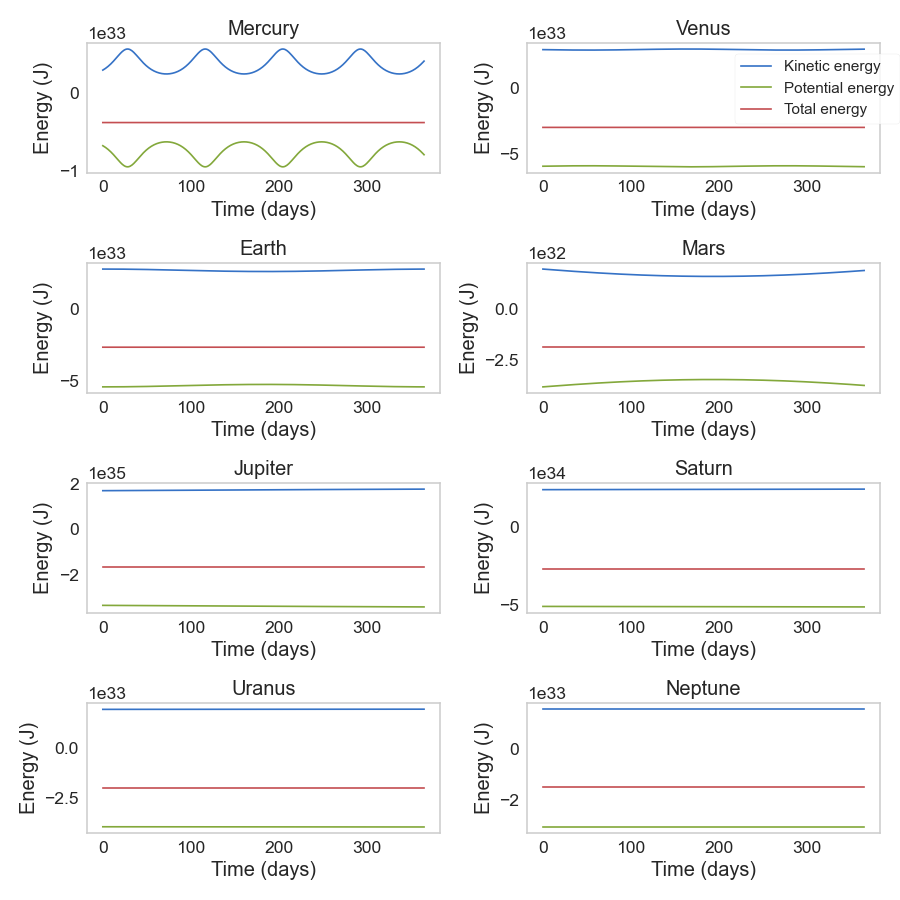

In [4]:
import numpy as np
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from tabulate import tabulate
from matplotlib.pyplot import figure, show

class SolarObject:
    """
    This class creates a solar object. When initiating a new solar object, the name, color and mass are required.
    When created, the objects get many variables which are used to store the data that is calculated further on.
    """
    def __init__(self, name, mass):
        self.name = name
        self.mass = mass
        self.r = np.array([])
        self.vel = np.array([])
        self.rTotal = np.array([])
        self.kinetic = np.array([])
        self.potential = np.array([])
        self.energy = 0
        self.momentum = np.array([])

# The value of one astronomical unit
AU = 1.495978707e11
# This is the gravitational constant in AU^3 * kg^-1 * day^-2
G = 6.67428e-11 * 86400**2 / (AU)**3

# Here I create all of the solar objects needed for the simulation
sun = SolarObject("Sun", 1.9885e30)
mercury = SolarObject("Mercury", 3.302e23)
venus = SolarObject("Venus", 4.8685e24)
earth = SolarObject("Earth", 5.97219e24)
mars = SolarObject("Mars", 6.4171e23)
jupiter = SolarObject("Jupiter", 1.89818722e27)
saturn = SolarObject("Saturn", 5.6834e26)
uranus = SolarObject("Uranus", 8.6813e25)
neptune = SolarObject("Neptune", 1.02413e26)

# Here you can change the startdate to whatever you want in the format yyyy-mm-dd
startdate = Time("2021-01-01").jd
# These are the id's that JPL Horizons uses for the Sun and the planets
ids = np.array([10, 199, 299, 399, 499, 599, 699, 799, 899])
# This is a list with all planets to ensure easier calculations
objects = np.array([sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune])
# In this loop all the necessary starting date is added
# The Horizons function fetches the data from JPL and then the data is stored for each object
for i in range(len(objects)):
    obj = Horizons(id = ids[i], location = "@sun", epochs = startdate, id_type = 'id').vectors()
    objects[i].r = np.array([obj["x"][0], obj["y"][0], obj["z"][0]])
    objects[i].vel = np.array([obj["vx"][0], obj["vy"][0], obj["vz"][0]])

# This is the step-value in days
dt = 1
# This is just a simple counter
c = 0
# The duration dictates for how many days the simulation will run, if dt = 1 is used
duration = 1 * 365
# In the following while loop the progression of the solar objects are calculated
# This while loop runs for as long as the given duration
while c < duration:
    # For each solar object we do the calculations
    for i in objects:
        # First I set these four values to 0
        # I use these further on and increase them, so each time they have to be 0 again
        acc = 0
        accPlus = 0
        potEnergy = 0
        angMoment = 0
        # Here I calculate the position to keep track of the objects
        # This way I can calculate the minimum, average and maximum distance
        i.rTotal = np.append(i.rTotal, np.sqrt(i.r[0]**2 + i.r[1]**2 + i.r[2]**2))
        # Here I calculate the speed in m/s
        speed = np.sqrt(i.vel[0]**2 + i.vel[1]**2 + i.vel[2]**2) * AU/86400
        # Here I calculate the kinetic energy and store it
        kinEnergy = 0.5 * i.mass * speed**2 
        i.kinetic = np.append(i.kinetic, kinEnergy)
        # Now I select the other objects from the list to use them for the 
        # calculation of the potential energy, angular moment and acceleration
        for j in objects:
            if i != j:
                # Here I calculate the distance with respect to other objects, which is
                # used for the potential energy and angular momentum
                dist = np.sqrt((i.r[0] - j.r[0])**2 + (i.r[1] - j.r[1])**2 + (i.r[2] - j.r[2])**2) * AU
                # Here I calculate the potential energy, angular momentum and acceleration with 
                # respect to each object and add them all together
                potEnergy += -6.67428e-11 * i.mass * j.mass/dist
                angMoment += i.mass * speed * dist
                acc += -G * (i.r - j.r) * j.mass / np.sum((i.r - j.r)**2)**(3/2)
        # Then I add the momentum and potential energy to the object
        i.momentum = np.append(i.momentum, angMoment)
        i.potential = np.append(i.potential, potEnergy)
        # Here I calculate the new position value for the object
        i.r = i.r + i.vel*dt + 0.5*acc*dt*dt
        # Now I calculate the acceleration again with regard to the new position value and
        # with respect to all the other objects
        # I use this value to increase the accuracy of the new velocity
        for j in objects:
            if i != j:
                accPlus += -G * (i.r - j.r) * j.mass / np.sum((i.r - j.r)**2)**(3/2)
        # Here I calculate the new velocity value using the first 
        # acceleration value and the new acceleration value
        i.vel = i.vel + 0.5*(acc + accPlus) * dt
        # Here I add the potential and kinetic energy to find the total energy
        i.energy = i.potential + i.kinetic
    # Here I increase the counter value
    c += 1

# This is the array with planets that I want to show data of
planets = np.array([mercury, venus, earth, mars, jupiter, saturn, uranus, neptune])
data = []
# In this loop I add all of the data together in a format that is used by the
# tabulate function
for i in range(len(planets)):
    data.append([planets[i].name, 
                 min(planets[i].rTotal), 
                 np.average(planets[i].rTotal), 
                 max(planets[i].rTotal), 
                 (max(planets[i].rTotal) - min(planets[i].rTotal))/(max(planets[i].rTotal) + min(planets[i].rTotal)), 
                 np.average(planets[i].kinetic), 
                 np.average(planets[i].potential), 
                 np.average(planets[i].momentum)])

# This is the tabulate function, which creates a table, given the 
# data and the headers
table = tabulate(data, headers = ["Planet", 
                                  "Minimum\ndistance\nto Sun (AU)",
                                  "Average\ndistance\nto Sun (AU)", 
                                  "Maximum\ndistance\nto Sun (AU)",
                                  "Eccentricity",
                                  "Average\nkinetic\nenergy (J)", 
                                  "Average\npotential\nenergy (J)", 
                                  "Average\nmomentum\n(Js)"], 
                 numalign = "center", 
                 tablefmt = "presto")
print(table)

# Here I create an array that represents the amount of days
# This makes it easier for plotting
x = np.linspace(0, duration, duration)
# Here I create the figure and all the frames
fig = figure(figsize = (9, 9))
frame1 = fig.add_subplot(4, 2, 1)
frame2 = fig.add_subplot(4, 2, 2)
frame3 = fig.add_subplot(4, 2, 3)
frame4 = fig.add_subplot(4, 2, 4)
frame5 = fig.add_subplot(4, 2, 5)
frame6 = fig.add_subplot(4, 2, 6)
frame7 = fig.add_subplot(4, 2, 7)
frame8 = fig.add_subplot(4, 2, 8)
# I add all the frames in one list to make it easier to plot
frames = [frame1, frame2, frame3, frame4, frame5, frame6, frame7, frame8]
# This loop does all the plotting for each planet
for i in range(len(frames)):
    frames[i].plot(x, planets[i].kinetic)
    frames[i].plot(x, planets[i].potential)
    frames[i].plot(x, planets[i].energy)
    frames[i].set_xlabel("Time (days)")
    frames[i].set_ylabel("Energy (J)")
    frames[i].set_title(planets[i].name)
# Here I create the legend and attach it to one place so there is only
# one legend. This makes the plot much clearer
fig.legend(("Kinetic energy", "Potential energy", "Total energy"), bbox_to_anchor=(1, 0.94), 
           borderaxespad=0., prop = {"size": 11})
fig.tight_layout()
show()

### Velocity over time
I use the next block of code to show how the velocity changes over time. I take Mercury as an example and you can really see how the velocity changes with respect to the distance from the Sun. The distance and velocity waves almost look like sine-waves that are shifted by half a phase. This is of course due to Kepler's second law, which states that a planet must sweep out equal areas of the orbit in equal amounts of time. I did not do this for other planets, because I think Mercury shows this the best and I think it would be a little chaotic with sixteen plots. If you want to see the plots for another planet, you only have to change the planet in line 94.

<IPython.core.display.Javascript object>


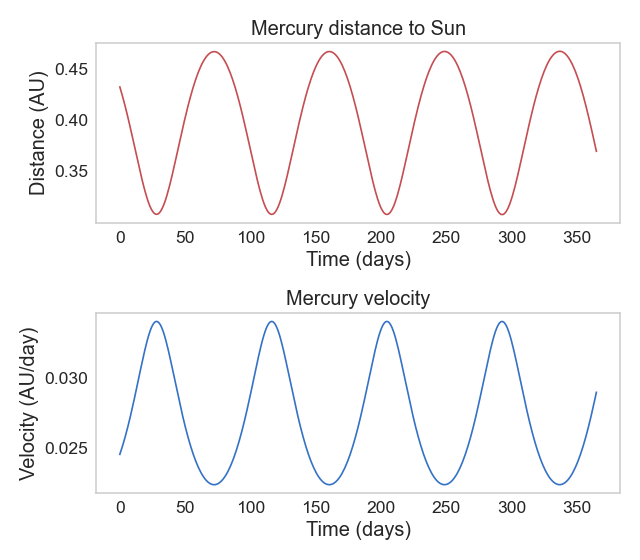

In [5]:
import numpy as np
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from matplotlib.pyplot import figure, show

class SolarObject:
    """
    This class creates a solar object. When initiating a new solar object, the name, color and mass are required.
    When created, the objects get many variables which are used to store the data that is calculated further on.
    """
    def __init__(self, name, mass):
        self.name = name
        self.mass = mass
        self.r = np.array([])
        self.vel = np.array([])
        self.rTotal = np.array([])
        self.velTotal = np.array([])
        self.kinetic = np.array([])
        self.potential = np.array([])
        self.energy = 0
        self.momentum = np.array([])

# The value of one astronomical unit
AU = 1.495978707e11
# This is the gravitational constant in AU^3 * kg^-1 * day^-2
G = 6.67428e-11 * 86400**2 / (AU)**3

# Here I create all of the solar objects needed for the simulation
sun = SolarObject("Sun", 1.9885e30)
mercury = SolarObject("Mercury", 3.302e23)
venus = SolarObject("Venus", 4.8685e24)
earth = SolarObject("Earth", 5.97219e24)
mars = SolarObject("Mars", 6.4171e23)
jupiter = SolarObject("Jupiter", 1.89818722e27)
saturn = SolarObject("Saturn", 5.6834e26)
uranus = SolarObject("Uranus", 8.6813e25)
neptune = SolarObject("Neptune", 1.02413e26)

# Here you can change the startdate to whatever you want in the format yyyy-mm-dd
startdate = Time("2021-01-01").jd
# These are the id's that JPL Horizons uses for the Sun and the planets
ids = np.array([10, 199, 299, 399, 499, 599, 699, 799, 899])
# This is a list with all planets to ensure easier calculations
objects = np.array([sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune])
# In this loop all the necessary starting date is added
# The Horizons function fetches the data from JPL and then the data is stored for each object
for i in range(len(objects)):
    obj = Horizons(id = ids[i], location = "@sun", epochs = startdate, id_type = 'id').vectors()
    objects[i].r = np.array([obj["x"][0], obj["y"][0], obj["z"][0]])
    objects[i].vel = np.array([obj["vx"][0], obj["vy"][0], obj["vz"][0]])

# This is the step-value in days
dt = 1
# This is just a simple counter
c = 0
# The duration dictates for how many days the simulation will run, if dt = 1 is used
duration = 1 * 365
# In the following while loop the progression of the solar objects are calculated
# This while loop runs for as long as the given duration
while c < duration:
    # For each solar object we do the calculations
    for i in objects:
        # First I set these two values to 0
        # I use these further on and increase them, so each time they have to be 0 again
        acc = 0
        accPlus = 0
        # Here I calculate the position to keep track of the objects
        # This way I can calculate the minimum, average and maximum distance
        i.rTotal = np.append(i.rTotal, np.sqrt(i.r[0]**2 + i.r[1]**2 + i.r[2]**2))
        # Here I calculate the velocity to keep track of it, so I can plot it
        i.velTotal = np.append(i.velTotal, np.sqrt(i.vel[0]**2 + i.vel[1]**2 + i.vel[2]**2))
        for j in objects:
            if i != j:
                # Here I calculate the acceleration with respect to other objects
                acc += -G * (i.r - j.r) * j.mass / np.sum((i.r - j.r)**2)**(3/2)
        # Here I calculate the new position value for the object
        i.r = i.r + i.vel*dt + 0.5*acc*dt*dt
        # Now I calculate the acceleration again with regard to the new position value and
        # with respect to all the other objects
        # I use this value to increase the accuracy of the new velocity
        for j in objects:
            if i != j:
                accPlus += -G * (i.r - j.r) * j.mass / np.sum((i.r - j.r)**2)**(3/2)
        # Here I calculate the new velocity value using the first 
        # acceleration value and the new acceleration value
        i.vel = i.vel + 0.5*(acc + accPlus) * dt
    # Here I increase the counter value
    c += 1

# Here I create an array that represents the amount of days
# This makes it easier for plotting
x = np.linspace(0, duration, duration)
# If you want to see the plots, you just have to change the planet here
planet = mercury
# Here I create the figure and the first frame
fig = figure()
frame1 = fig.add_subplot(2, 1, 1)
# Here I plot the data and set the title and labels
frame1.plot(x, planet.rTotal, "r")
frame1.set_title(str(planet.name) + " distance to Sun")
frame1.set_xlabel("Time (days)")
frame1.set_ylabel("Distance (AU)")

# Here I create the second frame
frame2 = fig.add_subplot(2, 1, 2)
# Here I plot the data and set the title and labels
frame2.plot(x, planet.velTotal)
frame2.set_title(str(planet.name) + " velocity")
frame2.set_xlabel("Time (days)")
frame2.set_ylabel("Velocity (AU/day)")

fig.tight_layout()
show()